In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from glob import glob
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from skimage import transform
import itertools as it
from sklearn.neighbors.kde import KernelDensity
import matplotlib.cm as cm
import queue
from skimage import morphology
import dlib
import cv2
from imutils import face_utils
from scipy.spatial import Delaunay

In [6]:
def cut_face(f_cascade, colored_img, scaleFactor = 1.1):
    #just making a copy of image passed, so that passed image is not changed 
    img_copy = colored_img.copy()

    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

    #let's detect multiscale (some images may be closer to camera than others) images
    faces = f_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=5)

    #go over list of faces and draw them as rectangles on original colored img
    i = 0
    for (x, y, w, h) in faces:
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)

        faceimg = img_copy[ny:ny+nr, nx:nx+nr]
        i += 1
        # cv2.imwrite("image%d.jpg" % i, faceimg)

    return faceimg

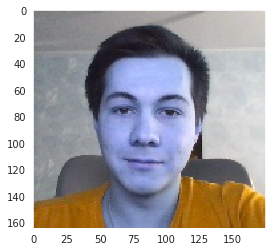

In [24]:
img_input_start = np.array(Image.open('maxim-min.jpg'))
plt.imshow(img_input_start)

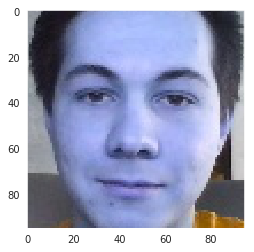

In [26]:
haar_face_cascade = cv2.CascadeClassifier('../data/haarcascade_frontalface_alt.xml') # create cascade classifier for face detection
# Face finder
img_input = cut_face(haar_face_cascade, img_input_start, scaleFactor = 1.1)
plt.imshow(img_input)

In [27]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../data/shape_predictor_68_face_landmarks.dat')

img_gray = cv2.cvtColor(cropImage, cv2.COLOR_BGR2GRAY)
rects = detector(img_gray, 0)
shape = predictor(img_gray, rects[0])
shape = face_utils.shape_to_np(shape)

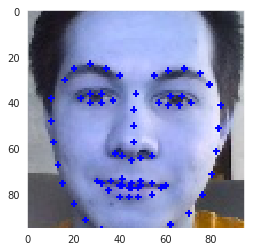

In [28]:
img_tmp = img_input.copy()
for x, y in shape:
    cv2.circle(img_tmp, (x, y), 1, (0, 0, 255), -1)
plt.imshow(img_tmp)

In [29]:
face_origin = sorted([(t.width()*t.height(), 
                       (t.left(), t.top(), t.width(), t.height())) 
                      for t in rects], 
                     key=lambda t: t[0], reverse=True)[0][1]

rescale = (1.3, 2.2, 1.3, 1.3)
(x, y, w, h) = face_origin
cx = x + w/2
cy = y + h/2

w = min(img_input.shape[1] - x, int(w/2 + rescale[2]*w/2))
h = min(img_input.shape[0] - y, int(h/2 + rescale[3]*h/2))

fx = max(0, int(x + w/2*(1 - rescale[0])))
fy = max(0, int(y + h/2*(1 - rescale[1])))
fw = min(img_input.shape[1] - fx, int(w - w/2*(1 - rescale[0])))
fh = min(img_input.shape[0] - fy, int(h - h/2*(1 - rescale[1])))

face = (fx, fy, fw, fh)

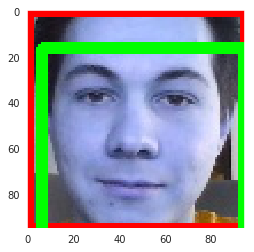

In [30]:
img_tmp = cv2.rectangle(img_input.copy(), (face[0], face[1]), 
                        (face[0] + face[2], face[1] + face[3]),
                        (255, 0, 0), thickness=3, lineType=8, shift=0)
img_tmp = cv2.rectangle(img_tmp, (face_origin[0], face_origin[1]), 
                        (face_origin[0] + face_origin[2], face_origin[1] + face_origin[3]),
                        (0, 255, 0), thickness=3, lineType=8, shift=0)
plt.imshow(img_tmp)

In [31]:
points = [shape[0].tolist(), shape[16].tolist()]
for ix in [4, 12, 8]:
    x, y = shape[ix].tolist()
    points.append((x, y))
    points.append((x, points[0][1] + points[0][1] - y))
    
hull = Delaunay(points)
xy_fg = []
for x, y in it.product(range(img_input.shape[0]), range(img_input.shape[1])):
    if hull.find_simplex([y, x]) >= 0:
        xy_fg.append((x, y))
print('xy_fg%:', len(xy_fg)/np.prod(img_input.shape))

xy_fg%: 0.21602954755309325


In [32]:
r = face[1]*face[3]/np.prod(img_input.shape[:2])
print(r)
k = 0.1

xy_bg_n = int(k*np.prod(img_input.shape[:2]))
print(xy_bg_n)

xy_bg = zip(np.random.uniform(0, img_input.shape[0], size=xy_bg_n).astype(np.int),
            np.random.uniform(0, img_input.shape[1], size=xy_bg_n).astype(np.int))
xy_bg = list(xy_bg)

xy_bg = [(x, y) for (x, y) in xy_bg 
         if y < face[0] or y > face[0] + face[2] or x < face[1] or x > face[1] + face[3]]
print(len(xy_bg)/np.prod(img_input.shape[:2]))

0.0
902
0.0


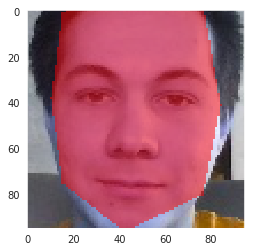

In [33]:
img_tmp = img_input/255.0
for x, y in xy_fg:
    img_tmp[x, y, :] = img_tmp[x, y, :]*0.5 + np.array([1, 0, 0]) * 0.5

for x, y in xy_bg:
    img_tmp[x, y, :] = img_tmp[x, y, :]*0.5 + np.array([0, 0, 1]) * 0.5
    
plt.imshow(img_tmp)

In [34]:
points_fg = np.array([img_input[x, y, :] for (x, y) in xy_fg])
points_bg = np.array([img_input[x, y, :] for (x, y) in xy_bg])

IndexError: too many indices for array

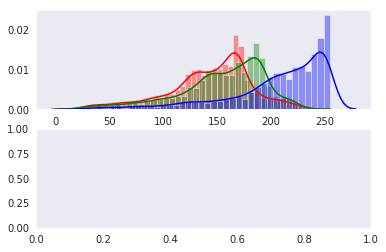

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1)
sns.distplot(points_fg[:, 0], ax=axes[0], color='r')
sns.distplot(points_fg[:, 1], ax=axes[0], color='g')
sns.distplot(points_fg[:, 2], ax=axes[0], color='b')
sns.distplot(points_bg[:, 0], ax=axes[1], color='r')
sns.distplot(points_bg[:, 1], ax=axes[1], color='g')
sns.distplot(points_bg[:, 2], ax=axes[1], color='b')